# 03 - Modeling

Treinar e comparar diferentes algoritmos de classificação, validação cruzada, tuning, avaliação.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import os

TRAIN_CSV = 'outputs/figures/predictions.csv'
TEST_CSV = 'data/processed/processed_seeds.csv'

df_train = pd.read_csv(os.path.abspath(TRAIN_CSV))
df_test = pd.read_csv(os.path.abspath(TEST_CSV))

df_train['class_name'] = df_train['class'].map({1:'Kama',2:'Rosa',3:'Canadian'})
df_test['class_name'] = df_test['class'].map({1:'Kama',2:'Rosa',3:'Canadian'})

## Preparar X_train, X_test com features escolhidas

In [14]:
def calc_compactness(area, perimeter): return 4*np.pi*area/(perimeter**2) if perimeter>0 else np.nan
for df in [df_train, df_test]:
    df['compactness_calc'] = df.apply(lambda r: calc_compactness(r['area'], r['perimeter']), axis=1)
    df['ratio_length_width'] = df['length'] / df['width'].replace({0: np.nan})
feature_cols = ['area','perimeter','compactness_calc','length','width','asymmetry','groove','ratio_length_width']
X_train = df_train[feature_cols].values
y_train = df_train['class'].values
X_test = df_test[feature_cols].values
y_test = df_test['class'].values

## Pipelines iniciais e Cross-Validation

In [15]:
pipelines = {
    'KNN': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]),
    'SVM': Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True))]),
    'RF': Pipeline([('clf', RandomForestClassifier(random_state=42))]),
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
results = {}
for name, pipe in pipelines.items():
    res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring)
    print(f"{name}: accuracy={res['test_accuracy'].mean():.3f}, f1={res['test_f1_macro'].mean():.3f}")

KNN: accuracy=0.923, f1=0.921
SVM: accuracy=0.928, f1=0.928
RF: accuracy=0.918, f1=0.917


## Hyperparameter Tuning (exemplo SVM)

In [16]:
param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear','rbf'],
    'clf__gamma': ['scale','auto']
}
pipe_svm = Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True))])
grid = GridSearchCV(pipe_svm, param_grid, cv=cv, scoring='accuracy')
grid.fit(X_train, y_train)
print('Melhores params SVM:', grid.best_params_)
print('Melhor score CV:', grid.best_score_)
best_svm = grid.best_estimator_

Melhores params SVM: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Melhor score CV: 0.9519163763066201


## Avaliação Final no Conjunto de Teste

              precision    recall  f1-score   support

        Kama       0.96      0.99      0.97        70
        Rosa       1.00      1.00      1.00        70
    Canadian       0.98      0.96      0.97        68

    accuracy                           0.98       208
   macro avg       0.98      0.98      0.98       208
weighted avg       0.98      0.98      0.98       208

Matriz de Confusão:
 [[69  0  1]
 [ 0 70  0]
 [ 3  0 65]]


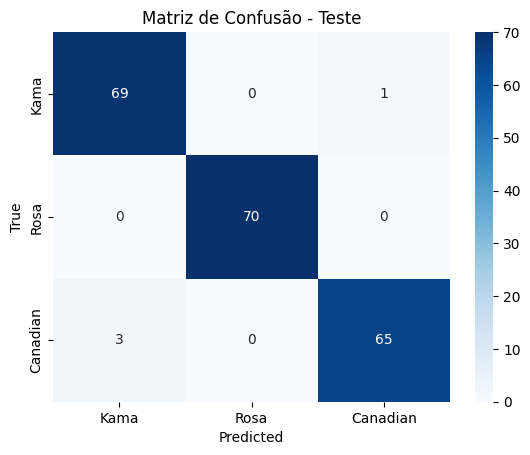

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = best_svm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Kama','Rosa','Canadian']))
cm = confusion_matrix(y_test, y_pred)
print('Matriz de Confusão:\n', cm)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Kama','Rosa','Canadian'], yticklabels=['Kama','Rosa','Canadian'], cmap='Blues')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.title('Matriz de Confusão - Teste')
plt.show()